In [1]:
import string
import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import gensim 

from sklearn.decomposition import PCA
from gensim.models import FastText as FT_gensim
from gensim.test.utils import datapath
from gensim.models.wrappers import FastText as FT
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_excel("../dataset_twitter.xlsx")
df.head()

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...


In [3]:
df = df[df.komentar.astype(bool)]

df_pos = df[df['label'] == 'positif']
X_pos_text = df_pos['komentar']
y_pos_label = df_pos['label']

df_neg = df[df['label'] == 'negatif']
X_neg_text = df_neg['komentar']
y_neg_label = df_neg['label']

df_net = df[df['label'] == 'netral']
X_net_text = df_net['komentar']
y_net_label = df_net['label']

In [4]:
# X_pos_train_down = resample(X_pos_text, replace=True, n_samples=int(len(X_net_text)))
# y_pos_train_down = resample(y_pos_label, replace=True, n_samples=int(len(y_net_label)))

# X_neg_train_down = resample(X_neg_train, replace=True, n_samples=int(len(X_net_text)))
# y_neg_train_down = resample(y_neg_train, replace=True, n_samples=int(len(y_net_label)))

df_pos_down = resample(df_pos, replace=True, n_samples=int(len(df_net)))
df_neg_down = resample(df_neg, replace=True, n_samples=int(len(df_net)))

In [5]:
# X_train = pd.concat([X_net_train, X_pos_train_down])
# X_train = pd.concat([X_train, X_neg_train_down])
# y_train = pd.concat([y_net_train, y_pos_train_down])
# y_train = pd.concat([y_train, y_neg_train_down])

# X_test = pd.concat([X_net_test, X_pos_test])
# X_test = pd.concat([X_test, X_neg_test])
# y_test = pd.concat([y_net_test, y_pos_test])
# y_test = pd.concat([y_test, y_neg_test])

df = pd.concat([df_net, df_pos_down])
df = pd.concat([df, df_neg_down])

In [6]:
df.label.value_counts()

positif    997
negatif    997
netral     997
Name: label, dtype: int64

In [7]:
komentar = df['komentar'].astype(str)

# Huruf kecil
komentar = komentar.apply(lambda x: x.lower())

# Hapus URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

# Hapus angka
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

# Hapus tanda baca
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Hapus diluar alphabet dan numeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

# Tokenizing data
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

komentar

2118    [orang, lain, kalau, pake, ponco, itu, buat, j...
2119    [pulang, udah, h, lebaran, dilema, sekali, sep...
2120    [sulit, menerima, kenyataan, memang, bahwa, ad...
2121    [separuh, hati, ini, iri, jika, melihat, seora...
2122    [dari, mau, tdr, tidur, sampe, bgn, tdr, kok, ...
                              ...                        
1122    [mak, lampir, dibully, karena, memberantas, ny...
1356    [gue, juga, gak, ada, masalah, dengan, gitasav...
1214    [siapa, sich, yg, dipercaya, fz, polisi, yg, s...
1026    [sedap, kali, kau, ya, bobok, dikasur, ku, aku...
1036    [nggak, ngerti, lagi, sama, ciwiciwi, yang, ny...
Name: komentar, Length: 2991, dtype: object

In [8]:
model_gensim = FT_gensim(size=300, 
                         negative=5, 
                         min_count=1, 
                         min_n=2, 
                         max_n=3, 
                         sg=0, 
                         sorted_vocab=1, 
                         word_ngrams=1, 
                         window=5, 
                         callbacks=(),
                         ns_exponent=0.75, 
                         cbow_mean=0, 
                         workers=5, 
                         alpha=0.1, 
                         min_alpha=0.025)

In [9]:
model_gensim.build_vocab(komentar)

In [10]:
total_examples = model_gensim.corpus_count
model_gensim.train(
    sentences=komentar,
    total_examples=total_examples, 
    epochs = 100
)

In [11]:
model_gensim.save('XGBDownSampling.bin')
loaded_model = FT_gensim.load('XGBDownSampling.bin')

In [12]:
loaded_model.wv.similarity("bagus", "buruk")

0.37622586

In [13]:
loaded_model.wv.distance("bagus", "jelek")

0.6302230358123779

In [14]:
loaded_model.wv.most_similar(positive="jelek", topn=5)

[('jeleknya', 0.8651484251022339),
 ('jek', 0.8622102737426758),
 ('jele', 0.8614435791969299),
 ('jelekin', 0.8608707785606384),
 ('melek', 0.7531708478927612)]

In [15]:
loaded_model.wv.most_similar_cosmul(positive="bagus", negative=None, topn=5)

[('agus', 0.9349910616874695),
 ('bagusnya', 0.9245906472206116),
 ('sebagus', 0.9173062443733215),
 ('bagusan', 0.9156389236450195),
 ('baguslah', 0.914813220500946)]

In [16]:
similar_words = {search_term: [item[0] for item in loaded_model.wv.most_similar([search_term], topn=5)]
                for search_term in ['mantap', 'keren', 'bagus', 'jelek', 'parah', 'cepat']}
similar_words

{'mantap': ['mantapp', 'mantan', 'mantanmu', 'mantanmantan', 'mangap'],
 'keren': ['kemren', 'kereta', 'kmren', 'ken', 'kelen'],
 'bagus': ['agus', 'bagusnya', 'sebagus', 'bagusan', 'baguslah'],
 'jelek': ['jeleknya', 'jek', 'jele', 'jelekin', 'melek'],
 'parah': ['parahu', 'parahnya', 'pasrah', 'para', 'arah'],
 'cepat': ['secepat', 'tepat', 'dipercepat', 'cenat', 'cepet']}

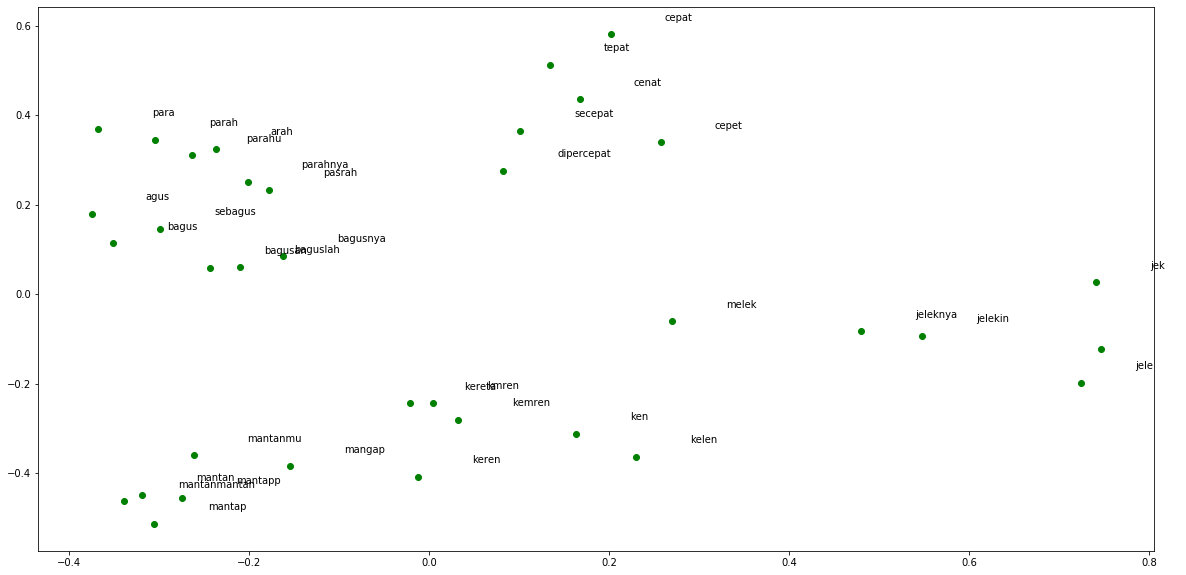

In [17]:
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = loaded_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(20, 10))
plt.scatter(P[:, 0], P[:, 1], c='green', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')